# Refine Woodward rules for alpha,beta substituted Carbonyl compounds


In [1]:
import sys, os
import pandas as pd
import numpy as np

from rdkit import Chem

sys.path.append('../../Woodward_Fieser_Rules-main/src/')
import chromopredict as cp

In [2]:
def get_wf_outputs(smiles, solvent=None, debug=False, extended=False):
    pred, d_contrib, img = cp.predict(smiles, solvent, debug=debug, draw=False, extended=extended)
    return pred, d_contrib, img

def get_wf_refine_outputs(smiles, solvent=None, debug=False, extended=False):
    pred, d_contrib, img = cp.woodward_refine_predict(smiles, solvent, debug=debug, draw=False)
    return pred, d_contrib, img


In [5]:
smi = 'CCCCCCCC[C@H]1C[C@@H](C2=C3[C@H](CC[C@]12C)[C@@]4(C)CC[C@@H](C[C@@H]4CC3=O)OC(=O)C)OC(=O)C'
pred_ori, c_ori, im_ori = get_wf_outputs(smi, debug=True)
pred_new, c_new, im_new = get_wf_refine_outputs(smi, debug=True)

c_ori

{'base': 215,
 'factor': 0,
 'exo': 5,
 'alpha': 'alkyl',
 'alpha_all': [{'pattern': 'alkyl', 'value': 10, 'sub_type': 'alpha'}],
 'beta': 'alkoxy',
 'beta_all': [{'pattern': 'alkoxy', 'value': 30, 'sub_type': 'beta'},
  {'pattern': 'alkyl', 'value': 12, 'sub_type': 'beta'}],
 'gamma': 'H',
 'gamma_all': [],
 'higher': 'H',
 'higher_all': [],
 'solvent': 0}

In [6]:
c_new

{'base': 215,
 'factor': 0,
 'exo': 5,
 'alpha': 'alkyl',
 'alpha_all': [{'pattern': 'alkyl', 'value': 14, 'sub_type': 'alpha'}],
 'beta': 'alkoxy',
 'beta_all': [{'pattern': 'alkoxy', 'value': 23, 'sub_type': 'beta'},
  {'pattern': 'alkyl', 'value': 17, 'sub_type': 'beta'}],
 'gamma': 'H',
 'gamma_all': [],
 'higher': 'H',
 'higher_all': [],
 'solvent': 0}

In [7]:
def unpack_data(df):
    # Constants
    HARTREE_TO_EV = 27.2116
    EV_TO_NM = 1239.841984  # Planck constant * speed of light in nm·eV

    # Function to convert string to list of floats
    def parse_str_array(s):
        s = s.strip("[]").replace("\n", " ")  # Remove brackets and newline
        return [float(x) for x in s.split()]
    
    # Apply the parsing function
    df['eigenvalues'] = df['eigenvalues'].apply(parse_str_array)
    df['oscillator_strengths'] = df['oscillator_strengths'].apply(parse_str_array)
    
    # Now unpack and convert
    for i in range(10):
        # Extract raw eigenvalue
        df[f'E{i+1}'] = df['eigenvalues'].apply(lambda x: x[i]) * HARTREE_TO_EV
        df[f'f{i+1}'] = df['oscillator_strengths'].apply(lambda x: x[i])
        df[f'nm{i+1}'] = df[f'E{i+1}'].apply(lambda x: round(EV_TO_NM / x,1) if x != 0 else np.nan)

    df = df.drop(columns=['eigenvalues', 'oscillator_strengths'])
    
    return df
    
def load_ref_data(path, category, func='b3lyp'):

    df_raw = pd.read_csv(path)
    df_unpack = unpack_data(df_raw)
    df_unpack['solvent'] = None
    df_unpack['moltype'] = category
    
    df_use = df_unpack[['smiles', 'moltype', 'solvent', 'nm2']].rename(columns={'nm2': 'nm_'+str(func)})

    return df_use
    

In [68]:
df_aldehydes_mix1 = load_ref_data('opt_dft/data_b3lyp_aldehyde_mix_calc_178V195.csv', func='b3lyp', category='aldehyde')
df_aldehydes_mix2 = load_ref_data('opt_dft/data_b3lyp_aldehyde_mix_calc_195V195.csv', func='b3lyp', category='aldehyde')
df_aldehydes_mono = load_ref_data('opt_dft/data_b3lyp_aldehyd_mono_calc_36v36.csv', func='b3lyp', category='aldehyde')

df_aldehydes = pd.concat([df_aldehydes_mix1, df_aldehydes_mix2, df_aldehydes_mono], axis=0)
df_aldehydes_clean = df_aldehydes.drop_duplicates(subset='smiles')
df_aldehydes_clean.count()


smiles      216
moltype     216
solvent       0
nm_b3lyp    216
dtype: int64

In [67]:
df_ketones_mix1 = load_ref_data('opt_dft/data_b3lyp_ketones_mix_calc_54V195.csv', func='b3lyp', category='ketone')
df_ketones_mix2 = load_ref_data('opt_dft/data_b3lyp_ketones_mix_calc_124V195.csv', func='b3lyp', category='ketone')
df_ketones_mono = load_ref_data('opt_dft/data_b3lyp_keton_mono_calc_36v36.csv', func='b3lyp', category='ketone')

df_ketones = pd.concat([df_ketones_mix1, df_ketones_mix2, df_ketones_mono], axis=0)
df_ketones_clean = df_ketones.drop_duplicates(subset='smiles')

df_ketones_clean.count()

smiles      154
moltype     154
solvent       0
nm_b3lyp    154
dtype: int64

In [69]:
df_acids_mix1 = load_ref_data('opt_dft/data_b3lyp_acids_mix_calc_72v195.csv', func='b3lyp', category='acid')
df_acids_mix2 = load_ref_data('opt_dft/data_b3lyp_acids_mix_calc_195v195.csv', func='b3lyp', category='acid')
df_acids_mono = load_ref_data('opt_dft/data_b3lyp_acid_mono_calc_36v36.csv', func='b3lyp', category='acid')

df_acids = pd.concat([df_acids_mix1, df_acids_mix2, df_acids_mono], axis=0)
df_acids_clean = df_acids.drop_duplicates(subset='smiles')
df_acids_clean.count()

smiles      216
moltype     216
solvent       0
nm_b3lyp    216
dtype: int64

In [70]:
df_all = pd.concat([df_aldehydes_clean, df_acids_clean, df_ketones_clean], axis=0) #, df_ketones_mono, df_acids_mono], axis=0)
df_all.head(n=5)

,smiles,moltype,solvent,nm_b3lyp
0,O=C/C(C)=C(C)\OC,aldehyde,None,258.6
1,O=C/C(C)=C(C)\Cl,aldehyde,None,256.8
2,O=C/C(C)=C(C)\Br,aldehyde,None,269.1
3,O=C/C(C)=C(C)\O,aldehyde,None,247.0
4,O=C/C(C)=C/C,aldehyde,None,239.6


In [71]:
df_all.count()

smiles      586
moltype     586
solvent       0
nm_b3lyp    586
dtype: int64

In [72]:
from rdkit import Chem
from rdkit.Chem import rdchem

def detect_cis_trans(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    for bond in mol.GetBonds():
        if bond.GetBondType() == rdchem.BondType.DOUBLE:
            stereo = bond.GetStereo()
            if stereo == rdchem.BondStereo.STEREOZ:
                return 'cis'
            elif stereo == rdchem.BondStereo.STEREOE:
                return 'trans'
    return 'no_stereo'

# Apply to create a mask
df_all['stereo_type'] = df_all['smiles'].apply(detect_cis_trans)

df_all.head(n=3)

,smiles,moltype,solvent,nm_b3lyp,stereo_type
0,O=C/C(C)=C(C)\OC,aldehyde,None,258.6,cis
1,O=C/C(C)=C(C)\Cl,aldehyde,None,256.8,cis
2,O=C/C(C)=C(C)\Br,aldehyde,None,269.1,cis


In [73]:
def get_wf_outputs(smiles, solvent=None, debug=False, extended=False):
    pred, d_contrib, img = cp.predict(smiles, solvent, debug=debug, draw=False, extended=extended)
    return pred, d_contrib, img #pd.Series([pred, d_contrib, img], index=['nm_wf', 'img_wf'])

def add_wf_predict(df):

    nm_wf = []
    img_wf = []
    contrib_wf = []

    nm_wfe = []
    img_wfe = []
    contrib_wfe = []
    
    for _, row in df.iterrows():
        smi = row['smiles']
        solv = row['solvent']
        # woodward
        nm, d_contrib, img = get_wf_outputs(smi, solv, debug=True, extended=False)
        nm_wf.append(nm)
        contrib_wf.append(d_contrib)
        img_wf.append(img)
        
        # woodward extended
        nm, d_contrib, img = get_wf_outputs(smi, solv, debug=True, extended=True)
        nm_wfe.append(nm)
        contrib_wfe.append(d_contrib)
        img_wfe.append(img)
        
        
    df['nm_wf'] = nm_wf
    df['nm_wfe'] = nm_wfe
    
    df['contrib_wf'] = contrib_wf
    df['contrib_wfe'] = contrib_wfe
    
    df['img_wf'] = img_wf
    df['img_wfe'] = img_wfe


In [74]:
add_wf_predict(df_all)


In [75]:
df_tmp = df_all[['moltype', 'smiles', 'solvent', 'stereo_type', 'nm_b3lyp', 'nm_wf', 'nm_wfe', 'contrib_wf']]

contrib_expanded = df_tmp['contrib_wf'].apply(pd.Series)
df_wf_all = pd.concat([df_tmp.drop(columns='contrib_wf'), contrib_expanded], axis=1)
df_wf_all['Nsub'] = df_wf_all.apply(
    lambda row: len(row['alpha_all']) + len(row['beta_all']),
    axis=1
)

df_wf_all.head(n=5)

,moltype,smiles,solvent,stereo_type,nm_b3lyp,nm_wf,nm_wfe,base,factor,exo,alpha,alpha_all,beta,beta_all,gamma,gamma_all,higher,higher_all,solvent,Nsub
0,aldehyde,O=C/C(C)=C(C)\OC,None,cis,258.6,250,247,210,0,0,alkyl,"[{'pattern': 'alkyl', 'value': 10, 'sub_type':...",alkoxy,"[{'pattern': 'alkoxy', 'value': 30, 'sub_type'...",H,[],H,[],0,3
1,aldehyde,O=C/C(C)=C(C)\Cl,None,cis,256.8,232,247,210,0,0,alkyl,"[{'pattern': 'alkyl', 'value': 10, 'sub_type':...",alkyl,"[{'pattern': 'alkyl', 'value': 12, 'sub_type':...",H,[],H,[],0,3
2,aldehyde,O=C/C(C)=C(C)\Br,None,cis,269.1,250,247,210,0,0,alkyl,"[{'pattern': 'alkyl', 'value': 10, 'sub_type':...",bromo,"[{'pattern': 'alkyl', 'value': 12, 'sub_type':...",H,[],H,[],0,3
3,aldehyde,O=C/C(C)=C(C)\O,None,cis,247.0,250,247,210,0,0,alkyl,"[{'pattern': 'alkyl', 'value': 10, 'sub_type':...",hydroxy,"[{'pattern': 'alkyl', 'value': 12, 'sub_type':...",H,[],H,[],0,3
4,aldehyde,O=C/C(C)=C/C,None,trans,239.6,232,236,210,0,0,alkyl,"[{'pattern': 'alkyl', 'value': 10, 'sub_type':...",alkyl,"[{'pattern': 'alkyl', 'value': 12, 'sub_type':...",H,[],H,[],0,2


In [94]:
df_4fit_wf = df_wf_all[['moltype', 'smiles', 'stereo_type', 'nm_b3lyp', 'nm_wf', 'nm_wfe', 'alpha', 'beta', 'Nsub']]
df_4fit_wf['base'] = df_4fit_wf['moltype'] #+ '_' + df_4fit_wf['stereo_type']

df_4fit_wf.head(n=5)

/tmp/ipykernel_690662/2286577748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4fit_wf['base'] = df_4fit_wf['moltype'] #+ '_' + df_4fit_wf['stereo_type']


,moltype,smiles,stereo_type,nm_b3lyp,nm_wf,nm_wfe,alpha,beta,Nsub,base
0,aldehyde,O=C/C(C)=C(C)\OC,cis,258.6,250,247,alkyl,alkoxy,3,aldehyde
1,aldehyde,O=C/C(C)=C(C)\Cl,cis,256.8,232,247,alkyl,alkyl,3,aldehyde
2,aldehyde,O=C/C(C)=C(C)\Br,cis,269.1,250,247,alkyl,bromo,3,aldehyde
3,aldehyde,O=C/C(C)=C(C)\O,cis,247.0,250,247,alkyl,hydroxy,3,aldehyde
4,aldehyde,O=C/C(C)=C/C,trans,239.6,232,236,alkyl,alkyl,2,aldehyde


In [95]:
# One-hot encode features
X_base = pd.get_dummies(df_4fit_wf['base'], prefix='base') #base
X_alpha = pd.get_dummies(df_4fit_wf['alpha'], prefix='alpha')
X_beta = pd.get_dummies(df_4fit_wf['beta'], prefix='beta')

# Combine into one feature matrix
X = pd.concat([X_base, X_alpha, X_beta], axis=1)
y = df_4fit_wf['nm_b3lyp']

feature_names = X.columns.tolist()

In [96]:
initial_guesses = {
    # Base values (from original Woodward rules)
    #'base_acid_cis': 195,
    #'base_acid_no_stereo': 195,
    #'base_acid_trans': 195,
    #'base_aldehyde_cis': 210,
    #'base_aldehyde_no_stereo': 210,
    #'base_aldehyde_trans': 210,
    #'base_ketone_cis': 215,
    #'base_ketone_no_stereo': 215,
    #'base_ketone_trans': 215,

    'base_ketone': 215,
    'base_aldehyde': 210,
    'base_acid': 195,
    
    # Alpha substituent increments (default = 0, unless known)
    'alpha_H': 0,
    'alpha_alkoxy': 35,
    'alpha_alkyl': 10,
    'alpha_bromo': 25,
    'alpha_chloro': 15,
    'alpha_hydroxy': 35,
    
    # Beta substituent increments (usually less than alpha)
    'beta_H': 0,
    'beta_alkoxy': 30,
    'beta_alkyl': 12,
    'beta_bromo': 30,
    'beta_chloro': 12,
    'beta_hydroxy': 30
}

x0 = np.array([initial_guesses.get(f, 0) for f in feature_names])
x0

array([195, 210, 215,   0,  35,  10,  25,  15,  35,   0,  30,  12,  30,
        12,  30])

### Fit Woodward parameters to DFT data

In [97]:
from scipy.optimize import dual_annealing
import numpy as np

# Define Loss Function
def integer_loss_fn(coefs):
    coefs_int = np.round(coefs)
    pred = X @ coefs_int
    return np.sum((pred - y) ** 2)

# Set bounds
bounds = []
for f in feature_names:
    if f in ['alpha_H', 'beta_H']:
        bounds.append((0, 0.001))
    #elif f in ['alpha_alkyl']:
    #    bounds.append((10, 10.001))
    #elif f in ['beta_alkyl']:
    #    bounds.append((12, 12.001))
    elif 'base' in f:
        bounds.append((150, 300))
    else:
        bounds.append((1, 50))

# Run global optimizer
result = dual_annealing(integer_loss_fn, bounds, x0=x0)

# Round final coefficients
fitted_int_coefs = np.round(result.x).astype(int)

# Convert to pandas Series
fitted_series = pd.Series(fitted_int_coefs, index=feature_names)

In [98]:
fitted_series


base_acid        196
base_aldehyde    219
base_ketone      212
alpha_H            0
alpha_alkoxy      31
alpha_alkyl       10
alpha_bromo       38
alpha_chloro      28
alpha_hydroxy     36
beta_H             0
beta_alkoxy       22
beta_alkyl        17
beta_bromo        33
beta_chloro       22
beta_hydroxy      15
dtype: int64

In [99]:
#acids
int((189+193+190)/3)

190

In [100]:
#aldehydes
int((215+211+217)/3)

214

In [101]:
#ketones
int((203+209+205)/3)

205

### Woodward vs. DFT-refined Woodward

Add updated list of values to dataset and compare original woodward predictiosn with refined values

In [102]:
def get_value(row, col_prefix):
    key = f"{col_prefix}_{row[col_prefix]}"
    #print(key)
    return fitted_series.get(key, 0)

In [103]:
df_4fit_wf['alpha_val'] = df_4fit_wf.apply(lambda row: get_value(row, 'alpha'), axis=1)
df_4fit_wf['beta_val']  = df_4fit_wf.apply(lambda row: get_value(row, 'beta'), axis=1)
df_4fit_wf['base_val']  = df_4fit_wf.apply(lambda row: get_value(row, 'base'), axis=1)

df_4fit_wf

/tmp/ipykernel_690662/4291798030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4fit_wf['alpha_val'] = df_4fit_wf.apply(lambda row: get_value(row, 'alpha'), axis=1)
/tmp/ipykernel_690662/4291798030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4fit_wf['beta_val']  = df_4fit_wf.apply(lambda row: get_value(row, 'beta'), axis=1)
/tmp/ipykernel_690662/4291798030.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,moltype,smiles,stereo_type,nm_b3lyp,nm_wf,nm_wfe,alpha,beta,Nsub,base,alpha_val,beta_val,base_val
0,aldehyde,O=C/C(C)=C(C)\OC,cis,258.6,250,247,alkyl,alkoxy,3,aldehyde,10,22,219
1,aldehyde,O=C/C(C)=C(C)\Cl,cis,256.8,232,247,alkyl,alkyl,3,aldehyde,10,17,219
2,aldehyde,O=C/C(C)=C(C)\Br,cis,269.1,250,247,alkyl,bromo,3,aldehyde,10,33,219
3,aldehyde,O=C/C(C)=C(C)\O,cis,247.0,250,247,alkyl,hydroxy,3,aldehyde,10,15,219
4,aldehyde,O=C/C(C)=C/C,trans,239.6,232,236,alkyl,alkyl,2,aldehyde,10,17,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,ketone,O=C(C)/C=C\OC,cis,228.1,245,224,H,alkoxy,1,ketone,0,22,212
32,ketone,O=C(C)/C=C\Cl,cis,223.4,227,224,H,chloro,1,ketone,0,22,212
33,ketone,O=C(C)/C=C\Br,cis,237.1,245,224,H,bromo,1,ketone,0,33,212
34,ketone,O=C(C)/C=C\O,cis,218.9,245,224,H,hydroxy,1,ketone,0,15,212


In [104]:
df_4fit_wf['nm_wf_refine'] = df_4fit_wf['alpha_val'] + df_4fit_wf['beta_val'] + df_4fit_wf['base_val']
df_4fit_wf.head(n=5)

/tmp/ipykernel_690662/1102069423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4fit_wf['nm_wf_refine'] = df_4fit_wf['alpha_val'] + df_4fit_wf['beta_val'] + df_4fit_wf['base_val']


,moltype,smiles,stereo_type,nm_b3lyp,nm_wf,nm_wfe,alpha,beta,Nsub,base,alpha_val,beta_val,base_val,nm_wf_refine
0,aldehyde,O=C/C(C)=C(C)\OC,cis,258.6,250,247,alkyl,alkoxy,3,aldehyde,10,22,219,251
1,aldehyde,O=C/C(C)=C(C)\Cl,cis,256.8,232,247,alkyl,alkyl,3,aldehyde,10,17,219,246
2,aldehyde,O=C/C(C)=C(C)\Br,cis,269.1,250,247,alkyl,bromo,3,aldehyde,10,33,219,262
3,aldehyde,O=C/C(C)=C(C)\O,cis,247.0,250,247,alkyl,hydroxy,3,aldehyde,10,15,219,244
4,aldehyde,O=C/C(C)=C/C,trans,239.6,232,236,alkyl,alkyl,2,aldehyde,10,17,219,246


In [105]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(df_4fit_wf['nm_wf'], df_4fit_wf['nm_wf_refine'])
mae

10.005119453924914

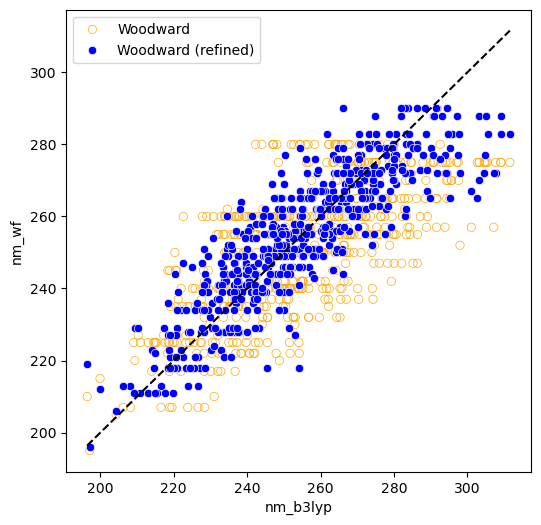

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf',
    marker='o',
    facecolors='none',
    edgecolor='orange',
    label='Woodward'
)

# Plot hollow circles for 'nm_wfe'
sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf_refine',
    marker='o',
    color='blue',
    label='Woodward (refined)'
)

# Add identity line for reference
plt.plot([df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         [df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         'k--', label='y = x')


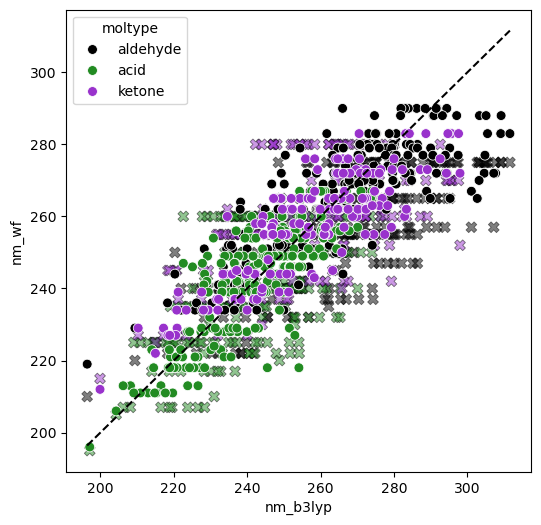

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf',
    hue='moltype',
    palette={'aldehyde': 'black', 'acid': 'forestgreen', 'ketone': 'darkorchid'},
    edgecolor='black',
    alpha=0.5,
    marker='X',
    #style='o', #'stereo_mismatch',
    s=60,
    legend=None, #{'Woodward', 'Woodward (stereo-mismatch)'}
)

# Plot hollow circles for 'nm_wfe'
sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf_refine',
    hue='moltype',
    palette={'aldehyde': 'black', 'acid': 'forestgreen', 'ketone': 'darkorchid'},
    edgecolor='white',
    marker='o',
    s=50,
    #legend=None, #'Woodward (refined)'
)

# Add identity line for reference
plt.plot([df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         [df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         'k--', label='y = x')


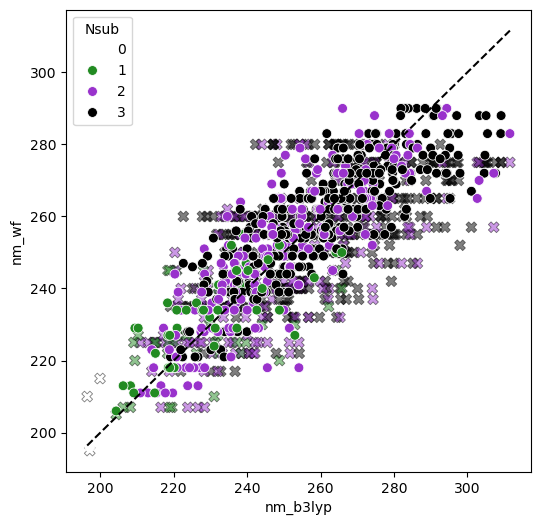

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf',
    hue='Nsub',
    palette={0: 'white', 1: 'forestgreen', 2: 'darkorchid', 3: 'black'},
    edgecolor='black',
    alpha=0.5,
    marker='X',
    #style='o', #'stereo_mismatch',
    s=60,
    legend=None, #{'Woodward', 'Woodward (stereo-mismatch)'}
)

# Plot hollow circles for 'nm_wfe'
sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf_refine',
    hue='Nsub',
    palette={0: 'white', 1: 'forestgreen', 2: 'darkorchid', 3: 'black'},
    edgecolor='white',
    marker='o',
    s=50,
    #legend=None, #'Woodward (refined)'
)

# Add identity line for reference
plt.plot([df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         [df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         'k--', label='y = x')


In [109]:
df_4fit_wf

,moltype,smiles,stereo_type,nm_b3lyp,nm_wf,nm_wfe,alpha,beta,Nsub,base,alpha_val,beta_val,base_val,nm_wf_refine
0,aldehyde,O=C/C(C)=C(C)\OC,cis,258.6,250,247,alkyl,alkoxy,3,aldehyde,10,22,219,251
1,aldehyde,O=C/C(C)=C(C)\Cl,cis,256.8,232,247,alkyl,alkyl,3,aldehyde,10,17,219,246
2,aldehyde,O=C/C(C)=C(C)\Br,cis,269.1,250,247,alkyl,bromo,3,aldehyde,10,33,219,262
3,aldehyde,O=C/C(C)=C(C)\O,cis,247.0,250,247,alkyl,hydroxy,3,aldehyde,10,15,219,244
4,aldehyde,O=C/C(C)=C/C,trans,239.6,232,236,alkyl,alkyl,2,aldehyde,10,17,219,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,ketone,O=C(C)/C=C\OC,cis,228.1,245,224,H,alkoxy,1,ketone,0,22,212,234
32,ketone,O=C(C)/C=C\Cl,cis,223.4,227,224,H,chloro,1,ketone,0,22,212,234
33,ketone,O=C(C)/C=C\Br,cis,237.1,245,224,H,bromo,1,ketone,0,33,212,245
34,ketone,O=C(C)/C=C\O,cis,218.9,245,224,H,hydroxy,1,ketone,0,15,212,227


In [110]:
df_2save_wf = df_4fit_wf[['smiles', 'nm_b3lyp', 'nm_wf', 'nm_wfe', 'nm_wf_refine']]

df_2save_wf.to_csv("smiles_absmax.csv", index=False)

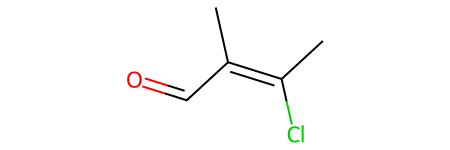

In [81]:
import rdkit

rdkit.Chem.MolFromSmiles('O=C/C(C)=C(C)\Cl')

In [107]:
def woodward_stereo_label_conditional(alpha, beta, current_stereo):
    HIGHER_PRIO = ['bromo', 'chloro', 'alkoxy', 'hydroxy']
    
    if current_stereo not in ['cis', 'trans']:
        # Leave unchanged if already 'no_stereo' or anything else
        return current_stereo
    
    # Now apply Woodward rules only if current stereo is cis or trans
    if alpha in HIGHER_PRIO and beta != 'H':
        return 'trans'
    elif alpha in HIGHER_PRIO and beta == 'H':
        return 'no_stereo'
    elif alpha in ['alkyl', 'H'] and beta != 'H':
        return 'cis'
    elif alpha == 'H' and beta == 'H':
        return 'no_stereo'
    else:
        return current_stereo  # fallback, keep current

def woodward_stereo_label_trans(alpha, beta, current_stereo):
    
    return 'trans'


In [108]:
#df_smi = df_4fit_wf[['smiles', 'stereo_type']]
df_4fit_wf['wf_stereo_label'] = df_4fit_wf.apply(
    lambda row: woodward_stereo_label_conditional(row['alpha'], row['beta'], row['stereo_type']),axis=1
)


df_4fit_wf['stereo_mismatch'] = (df_4fit_wf['stereo_type'] != df_4fit_wf['wf_stereo_label']).astype(int)

df_4fit_wf

,moltype,smiles,stereo_type,nm_b3lyp,nm_wf,alpha,beta,base,alpha_val,beta_val,base_val,nm_wf_refine,wf_stereo_label,stereo_mismatch
0,aldehyde,O=C/C(C)=C(C)\OC,cis,258.6,250,alkyl,alkoxy,aldehyde,15,17,221,253,cis,0
1,aldehyde,O=C/C(C)=C(C)\Cl,cis,256.8,232,alkyl,alkyl,aldehyde,15,12,221,248,cis,0
2,aldehyde,O=C/C(C)=C(C)\Br,cis,269.1,250,alkyl,bromo,aldehyde,15,28,221,264,cis,0
3,aldehyde,O=C/C(C)=C(C)\O,cis,247.0,250,alkyl,hydroxy,aldehyde,15,11,221,247,cis,0
4,aldehyde,O=C/C(C)=C/C,trans,239.6,232,alkyl,alkyl,aldehyde,15,12,221,248,cis,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,ketone,O=C(C)/C=C\OC,cis,228.1,245,H,alkoxy,ketone,0,17,211,228,cis,0
32,ketone,O=C(C)/C=C\Cl,cis,223.4,227,H,chloro,ketone,0,19,211,230,cis,0
33,ketone,O=C(C)/C=C\Br,cis,237.1,245,H,bromo,ketone,0,28,211,239,cis,0
34,ketone,O=C(C)/C=C\O,cis,218.9,245,H,hydroxy,ketone,0,11,211,222,cis,0


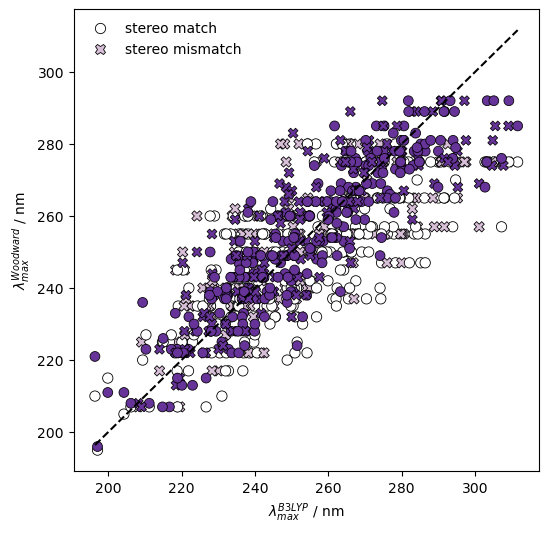

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# Create the plot
ax = sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf',
    hue='stereo_mismatch',
    palette={0: 'white', 1: 'thistle'},
    edgecolor='black',
    style='stereo_mismatch',
    #marker='X',
    s=55,
)

# Customize legend labels
new_labels = ['stereo match', 'stereo mismatch']
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=new_labels, title=None, frameon=False)

# Plot hollow circles for 'nm_wfe'
sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf_refine',
    #hue='stereo_mismatch',
    #palette={0: 'black', 1: 'purple'},
    edgecolor='black',
    facecolor='rebeccapurple',
    style='stereo_mismatch',
    #marker='o',
    s=50,
    legend=None, #'Woodward (refined)'
)

# Add identity line for reference
plt.plot([df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         [df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         'k--', label='y = x')


plt.xlabel('$\lambda_{max}^{B3LYP}$ / nm')
plt.ylabel('$\lambda_{max}^{Woodward}$ / nm')

plt.show()

<Axes: xlabel='stereo_type', ylabel='nm_wf_refine'>

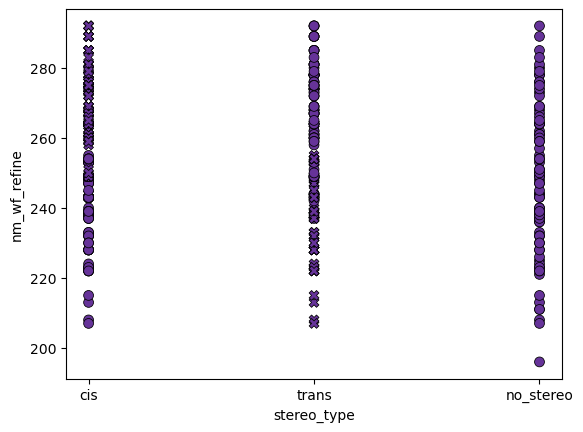

In [110]:
sns.scatterplot(
    data=df_4fit_wf,
    x='stereo_type',
    y='nm_wf_refine',
    #hue='stereo_mismatch',
    #palette={0: 'black', 1: 'purple'},
    edgecolor='black',
    facecolor='rebeccapurple',
    style='stereo_mismatch',
    #marker='o',
    s=50,
    legend=None, #'Woodward (refined)'
)



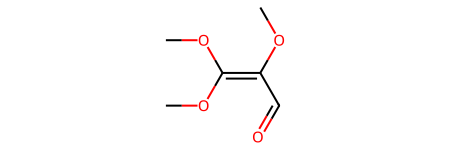

In [67]:
rdkit.Chem.MolFromSmiles('O=CC(OC)=C(OC)OC')

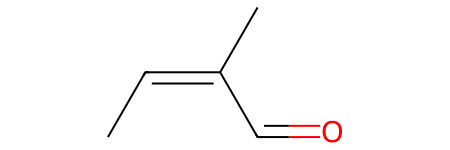

In [68]:
rdkit.Chem.MolFromSmiles('C/C=C(/C)C=O')

In [69]:
detect_cis_trans('C/C=C(\C)C=O')

'trans'